In [1]:
import torchvision 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms   
import torch.optim as optim
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from PIL import Image
from numpy.linalg import norm
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn.utils.prune as prune
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
#!pip install opacus


In [2]:
import scipy
mat = scipy.io.loadmat('/notebooks/data_cifar100_train.mat')
mat2 = scipy.io.loadmat('/notebooks/data_cifar100_test.mat')
lab = scipy.io.loadmat('/notebooks/label_train.mat')
lab2 = scipy.io.loadmat('/notebooks/label_test.mat')

data = mat['data'] # use the key for data here
target = lab['data']

data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long() # change type to your use case
target = torch.flatten(target)

data2 = mat2['data'] # use the key for data here
target2 = lab2['data']

data2 = torch.from_numpy(data2).float()
target2 = torch.from_numpy(target2).long() # change type to your use case
target2 = torch.flatten(target2)
dataset = torch.utils.data.TensorDataset(data, target)
testset = torch.utils.data.TensorDataset(data2, target2)

indices = list(range(0, 50000,1))
trainset1 = torch.utils.data.Subset(dataset, indices)
modelloader = torch.utils.data.DataLoader(trainset1, shuffle=True, num_workers=2, batch_size = 5000)

valid = list(range(40000, 50000,1))
validset1 = torch.utils.data.Subset(dataset, valid)
validloader = torch.utils.data.DataLoader(validset1, shuffle=True, num_workers=2,batch_size = 100)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 100)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
import random
from opacus import PrivacyEngine
matrix = np.array([])
count = 1
avg = 0 
topacc = 0
for i in range(100): 
    print("##########################################################")
    print("#########################################################")
    print("trial: " + str(i))
    #indices = torch.randperm(len(dataset))[:1000]
    indices = list(range(0, 10000,1))
    indices_to_remove = random.sample(range(len(indices)), 1)
    indices_to_remove.sort(reverse=True)
    for index in indices_to_remove:
        del indices[index]
    print(np.shape(indices))
    trainset1 = torch.utils.data.Subset(dataset, indices)
    modelloader = torch.utils.data.DataLoader(trainset1, shuffle=False, num_workers=2, batch_size = 10000)
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 100)
    model = nn.Sequential( nn.Linear(1024, 10)).to(device)
    model.load_state_dict(torch.load("/notebooks/start"))
    model.to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9,nesterov= True)
    #torch.optim.Adam(model.parameters(), lr = 0.01)
     #torch.optim.SGD(model.parameters(), lr = 0.01,momentum = 0.9, nesterov= True)
    
    privacy_engine = PrivacyEngine()

    model, optimizer, modelloader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=modelloader,
        noise_multiplier=1.0,
        max_grad_norm=0.1,
    )
    
  ################
  #training model
  ####################
    train_losslist = []
    n_epochs = [*range(100)]
    
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in n_epochs:
    # keep track of training and validation loss
        train_loss = 0.0
        train_loss1 = 0.0
        valid_loss = 0.0   
    ###################
    # train the model #
    ###################
        model.train()
    #model1.train()
        class_correct1 = list(0. for i in range(10))
        class_total1 = list(0. for i in range(10))
        for data, target in modelloader:
        # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
            optimizer.zero_grad()
        #optimizer1.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
        #output1 = model1(data)
        # calculate the batch loss
            loss = criterion(output, target)
        #loss1 = criterion1(output1,target)
        # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
          #########  nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=2)
        #loss1.backward()
        # perform a single optimization step (parameter update)
            optimizer.step()
        #exp_lr_scheduler.step()
        #optimizer1.step()
        # update training loss
            train_loss += loss.item()*data.size(0)
        #train_loss1 += loss1.item()*data.size(0)
            _, pred = torch.max(output, 1)    
        # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            
        # calculate test accuracy for each object class
    ########################
    # testing model #
    ######################### 
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.
    train_on_gpu = torch.cuda.is_available()
    model.eval()
    # iterate over test data
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(100):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    # average test loss
    test_loss = test_loss/len(modelloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        else:(' uracy of %5s: N/A (no training examples)' % (classes[i]))
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))        
    avg += (100. * np.sum(class_correct) / np.sum(class_total))
    if(np.sum(class_correct) / np.sum(class_total)*100. > topacc):
        topacc = np.sum(class_correct) / np.sum(class_total)*100.
        torch.save(model.state_dict(), "9999100ep0.1lropacustop")   
    print(privacy_engine.get_epsilon(delta=1e-04))
    arr = np.array([])
    for name, param in model.named_parameters():
        temp = param.cpu().detach().numpy()
        bruh = temp.flatten()
        arr =np.concatenate((arr,bruh),axis = 0)
    arr =np.reshape(arr, (1,-1))
    if matrix.size == 0:
        matrix = arr
    else: 
        matrix = np.append(matrix, arr, axis = 0)
    count = count +1
print(avg/300)
np.save('30010k1pointremoval100epoch0.1lropacus.npy', matrix)

##########################################################
#########################################################
trial: 0
(9999,)
Test Loss: 1.630762

Test Accuracy of airplane: 37% (378/1000)
Test Accuracy of automobile: 90% (909/1000)
Test Accuracy of  bird: 12% (126/1000)
Test Accuracy of   cat: 45% (451/1000)
Test Accuracy of  deer: 37% (372/1000)
Test Accuracy of   dog: 48% (483/1000)
Test Accuracy of  frog: 95% (959/1000)
Test Accuracy of horse: 82% (822/1000)
Test Accuracy of  ship: 89% (894/1000)
Test Accuracy of truck: 58% (589/1000)

Test Accuracy (Overall): 59% (5983/10000)


/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:53: RuntimeWarning: divide by zero encountered in log
  t > np.log(1 - q),
/usr/local/lib/python3.9/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: divide by zero encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


86.3538701380763
##########################################################
#########################################################
trial: 1
(9999,)
Test Loss: 1.630689

Test Accuracy of airplane: 37% (377/1000)
Test Accuracy of automobile: 91% (910/1000)
Test Accuracy of  bird: 12% (129/1000)
Test Accuracy of   cat: 45% (450/1000)
Test Accuracy of  deer: 37% (374/1000)
Test Accuracy of   dog: 48% (482/1000)
Test Accuracy of  frog: 95% (959/1000)
Test Accuracy of horse: 82% (821/1000)
Test Accuracy of  ship: 89% (892/1000)
Test Accuracy of truck: 58% (588/1000)

Test Accuracy (Overall): 59% (5982/10000)
86.3538701380763
##########################################################
#########################################################
trial: 2
(9999,)
Test Loss: 1.630594

Test Accuracy of airplane: 37% (376/1000)
Test Accuracy of automobile: 91% (910/1000)
Test Accuracy of  bird: 12% (128/1000)
Test Accuracy of   cat: 44% (449/1000)
Test Accuracy of  deer: 37% (375/1000)
Test Accurac

0
average accuracy after 0 iterations:11.710000000000003
[0.]
[11.71]
1
average accuracy after 1 iterations:41.691
[0.         0.00035972]
[11.71  41.691]
2
average accuracy after 2 iterations:54.673000000000016
[0.         0.00035972 0.00055825]
[11.71  41.691 54.673]
3
average accuracy after 3 iterations:61.649
[0.         0.00035972 0.00055825 0.00076609]
[11.71  41.691 54.673 61.649]
4
average accuracy after 4 iterations:63.416
[0.         0.00035972 0.00055825 0.00076609 0.00112944]
[11.71  41.691 54.673 61.649 63.416]
5
average accuracy after 5 iterations:65.83500000000001
[0.         0.00035972 0.00055825 0.00076609 0.00112944 0.00144285]
[11.71  41.691 54.673 61.649 63.416 65.835]
6
average accuracy after 6 iterations:67.583
[0.         0.00035972 0.00055825 0.00076609 0.00112944 0.00144285
 0.00182806]
[11.71  41.691 54.673 61.649 63.416 65.835 67.583]
7
average accuracy after 7 iterations:68.34800000000001
[0.         0.00035972 0.00055825 0.00076609 0.00112944 0.00144285
 0.

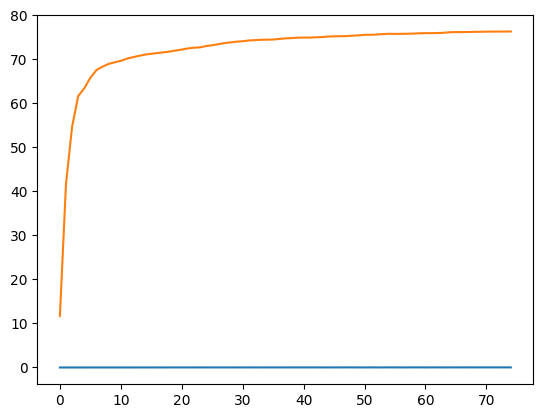

In [3]:
import random
def l2normupdated(data,size):
    count = 0
    total = 0
    avg = np.array([])
    for i in range(size):
        if i ==0:
            avg = data[i]
        else:
            avg = avg+data[i]
    avg = avg/size
    for i in range(size):
        data1 = avg-data[i]
        total += np.linalg.norm(data1)
    return total/size
toplot = np.array([])
toplot2 = np.array([])
for a in range(75):
    print(a)
    matrix = np.array([])
    count = 1
    avg = 0 
    topacc = 0
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 100)
    for i in range(10): 
        #indices = torch.randperm(len(dataset))[:1000]
        #removing indices
        indices = list(range(0,5000,1))
        indices_to_remove = random.sample(range(len(indices)), 1)
        indices_to_remove.sort(reverse=True)
        for index in indices_to_remove:
            del indices[index]
       # print(np.shape(indices))
        #dataset defined
        trainset1 = torch.utils.data.Subset(dataset, indices)
        modelloader = torch.utils.data.DataLoader(trainset1, shuffle=False, num_workers=2, batch_size = 5000)
        #model define
        model = nn.Sequential( nn.Linear(1024, 10)).to(device)
        model.load_state_dict(torch.load("/notebooks/start"))
        model.to(device) 
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9,nesterov= True)
      ################
      #training model
      ####################
        train_losslist = []
        n_epochs = [*range(a)]
        valid_loss_min = np.Inf # track change in validation loss
        for epoch in n_epochs:
            train_loss = 0.0
            train_loss1 = 0.0
            valid_loss = 0.0   
            model.train()
            for data, target in modelloader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*data.size(0)

        ########################
        # testing model #
        ######################### 
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        test_loss = 0.
        train_on_gpu = torch.cuda.is_available()
        model.eval()
        # iterate over test data
        for data, target in testloader:
            
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            loss = criterion(output, target)
            # update test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(100):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        # average test loss     
        avg += (100. * np.sum(class_correct) / np.sum(class_total))
        arr = np.array([])
        for name, param in model.named_parameters():
            temp = param.cpu().detach().numpy()
            bruh = temp.flatten()
            arr =np.concatenate((arr,bruh),axis = 0)
        arr =np.reshape(arr, (1,-1))
        if matrix.size == 0:
            matrix = arr
        else: 
            matrix = np.append(matrix, arr, axis = 0)
    print(f"average accuracy after {a} iterations:{avg/10}")
    l2norm = l2normupdated(matrix,10)
    if toplot.size == 0:
        toplot = np.array([l2norm])
    else: 
        toplot = np.append(toplot, l2norm)
    if toplot2.size == 0:
        toplot2 = np.array([avg/10])
    else: 
        toplot2 = np.append(toplot2, avg/10)
    print(toplot)
    print(toplot2)
plt.plot(toplot)
plt.plot(toplot2)

"\nmatrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)\nmatrix = np.append(toplot2, matrix2)\nprint(matrix)\nnp.save('/notebooks/acc65to75it20k.npy', matrix2)\n\nmatrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)\nmatrix = np.append(toplot, matrix2)\n\nnp.save('/notebooks/l2norm75it20k.npy', matrix)\n"

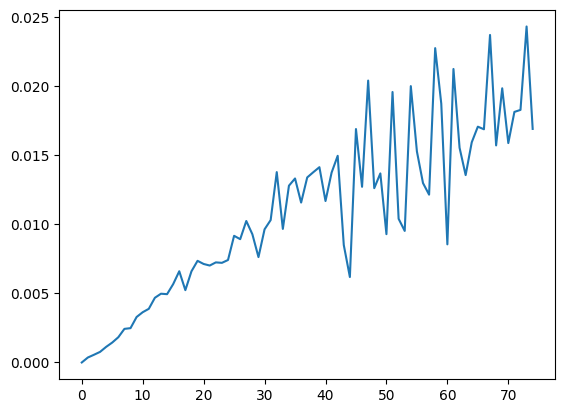

In [4]:

plt.plot(toplot)
np.save('l2norm75it5k.npy', toplot)
np.save('acc75it5k.npy', toplot2)
"""
matrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)
matrix = np.append(toplot2, matrix2)
print(matrix)
np.save('/notebooks/acc65to75it20k.npy', matrix2)

matrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)
matrix = np.append(toplot, matrix2)

np.save('/notebooks/l2norm75it20k.npy', matrix)
"""

10k 100 epoch 0.01 lr avg acc: 71.93 

10k 50 epoch 0.1 lr avg acc: 75.72

10k 100 epoch 0.1 lr avg acc: 77.04

10k 100 epoch 0.1 lr avg acc: 76.88

10k 100 epoch 0.05 lr avg acc: 75.87

10k 100 epoch 0.1 lr 0.25 grad: 75.62

10k 100 epoch 0.1 lr 0.1 grad: 76.48

10k 100 epoch 0.1 lr 0.05 grad: 74.8

10k 200 epoch 0.1 lr 0.05 grad: 77.3


1k 100 epoch 0.01 lr avg acc: 71.06

1k 50 epoch 0.1 lr avg acc: 73.36

1k 100 epoch 0.1 lr avg acc: 73.67

1k 100 epoch 0.05 lr avg acc: 73.55

1k 100 epoch 0.25 grad 0.1 lr : 73.64



20k 50 epoch 0.1 lr avg acc: 75.9288

20k 50 epoch 0.1 lr avg acc: 76.84

20k 100 epoch 0.1 lr avg acc: 77.44

20k 100 epoch 0.1 lr 0.25 grad: 77.24

20k 100 epoch 0.1 lr 0.1 grad: 76.8


10k 10 point removal 100 epoch 0.1 lr no grad: 77.13
10k 100 point removal 100 epoch 0.1 lr no grad: 77.07
10k 1000 point removal 100 epoch 0.1 lr no grad: 76.983
10k 2500 point removal 100 epoch 0.1 lr no grad: 76.86
10k 5000 point removal 100 epoch 0.1 lr no grad: 76.56




